_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 100)               4300      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 14)                714       
Total params: 10,064
Trainable params: 10,064
Non-trainable params: 0
_________________________________________________________________
2/2 [=

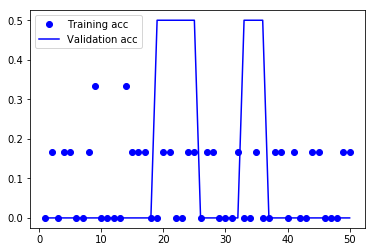

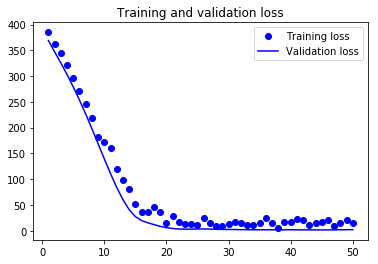

In [167]:
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# set parameters:
base_dir = "/Users/akanane/Documents/Research/ML_diffraction/data/AuPtSL20x20x7-1"
dirs = ['0A','2B','2C','2D','2E','2F','2G','2H','2I','2J']  # 2A conv C does not exist

ndata = 102
test_size = 0.2
validation_size = 0.25
batch_size = 2
epochs = 50

# read everything in...
difr, qgrid = read_data(base_dir, dirs, ndata)

# x array contains the input: (ntrain, train_vector)
x = get_input(qgrid, difr)
y = get_labels(base_dir, dirs, x.shape[0])

# build neural network:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# create a NN model:
model_DNN = compile_model(x.shape[1], y.shape[1])

#early stopping:
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(('chk_model.h5'), save_best_only=True,
             save_weights_only=False)]

# train DNN and store training info in history
history = model_DNN.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False,
                        #callbacks=callbacks,
                        validation_split=validation_size
                        #validation_data=(x_test, y_test)
                        )

# evaluate model and predict
y_pred = model_DNN.predict(x_test)
score  = model_DNN.evaluate(x_test, y_test, verbose=1)

# compare two selected cases, calculate errors:
print (y_pred[0,:])
print (y_test[0,:])
mae  = np.sum(np.abs(y_pred[0,:]-y_test[0,:]))/len(y_pred[0,:])
rmsd = np.sqrt(np.sum(np.square(np.abs(y_pred[0,:]-y_test[0,:])))/len(y_pred[0,:]))

print (" MAE ", mae)
print (" RMSD ", rmsd)

# plot training statistics:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

nepochs = range(1, len(acc)+1)

plt.plot(nepochs, acc, 'bo', label='Training acc')
plt.plot(nepochs, val_acc, 'b', label='Validation acc')
plt.legend()

plt.figure()

plt.plot(nepochs, loss, 'bo', label="Training loss")
plt.plot(nepochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [163]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.activations import elu

def create_DNN(n_features, n_out):
    # instantiate model
    model = Sequential()
    
    alpha = 0.1
    model.add(Dense(100,input_shape=(n_features,)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dense(n_out, activation='linear'))
    
    model.summary()
    
    return model

In [9]:
def read_data(base_dir, dirs, ndata):
    
    scaling_factor = 1e10
    
    # Q grid is only needed if we want to plot diffraction
    # pattern, it is not used in the GPR model
    # take low Q features with Q=[25,29]
    # and high Q features with Q=[51,58]
    qminL = 25.0
    qmaxL = 29.0
    qminH = 51.0
    qmaxH = 58.0
    dq = 0.01
    
    NQgridL = int((qmaxL - qminL)/dq)
    NQgridH = int((qmaxH - qminH)/dq)
    NQgrid = NQgridL + NQgridH
    
    dp = np.zeros((ndata, NQgrid))
    qgridL = np.linspace(qminL, qmaxL, NQgridL, False)
    qgridH = np.linspace(qminH, qmaxH, NQgridH, False)
    
    qgrid = np.concatenate((qgridL, qgridH), axis=0)
    
    ndir = len(dirs)
    difr = np.zeros((ndir,ndata,NQgrid))
    
    # read xrd files
    for ind_d, d in enumerate(dirs):
        for n in range(ndata):
            filename = base_dir + "/AuPtSLxrd" + d + "20x20x7-C/AuPtSLxrd" + d + "20x20x7-"+str(n)+"C"
            f = open(filename,"r")
            m = 0
            for line in f:
                line2 = line.split()
                qval = float(line2[0])
                ints = float(line2[1])
                if qval >= qminL and qval < qmaxL:
                    difr[ind_d, n, m] = ints
                    m += 1
                if qval >= qminH and qval < qmaxH:
                    difr[ind_d, n, m] = ints
                    m += 1
            f.close()
    
    difr[:,:,:] /= scaling_factor
    
    return difr, qgrid

In [10]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_compare(x, y, x1, y1):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g')
    ax.plot(x1, y1, color='r', ls=':')
    ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [13]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_difference(x, y, y1):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y-y1, color='g')
    #ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [24]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_single(x, y):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g')
    #ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [116]:
def peak_positions(x, y):
    
    cutoff = 0.05
    peaks = []
    ints = []
    z = sorted(y, reverse=True)
    
    for n in range(len(z)):
        val = z[n]
        tmp = np.where(y==val)[0]
        ind = tmp[0]
        if ind+1 < len(z):
            left = y[ind-1]
            righ = y[ind+1]
            if left < val and righ < val and val > cutoff:
                #print (" peak detected ",val,x[ind])
                peaks.append(x[ind])
                ints.append(val)
    
    return sorted(peaks), ints

In [125]:
def get_input(qgrid, difr):
    """
        Calculate input by concatenating vectors of intensities
        at some number of time points
    """
    
    ntrain = difr.shape[0]
    ntimes = difr.shape[1]
    
    nmax = 200
    
    x = np.zeros((ntrain, nmax))
    
    for n in range(ntrain):
        for t in range(0,60,10):
            peaks, ints = peak_positions(qgrid, difr[n,t,:])
            if t == 0:
                allints = ints
            else:
                allints = np.concatenate((allints, ints), axis=0)
        if n==0:
            nz = len(allints)
        else:
            assert nz == len(allints), " different length of input data for different samples"
            
        x[n,:nz] = allints[:]
        
    xo = np.zeros((ntrain,nz))
    
    xo[:,:] = x[:,:nz]
            
    return xo

In [135]:
def get_labels(base_dir, dirs, ndata):
    
    nlayers = 14
    
    y = np.zeros((ndata, nlayers))
    
    for ind_d, d in enumerate(dirs):
        filename = base_dir + "/AuPtSLxy" + d + "20x20x7/AuPtSLxy" + d + "20x20x7-0"
        f = open(filename,"r")
        m = 0
        for line in f:
            line2 = line.split()
            v1 = float(line2[0])
            v2 = float(line2[1])
            y[ind_d, m] = v1
            y[ind_d, m+7] = v2
            m += 1
            if m == 7:
                break
        f.close()
            
    return y

In [153]:
from keras import optimizers

def compile_model(n_features, n_out):
    
    # create the model
    model=create_DNN(n_features, n_out)
    # compile the model
    model.compile(loss=keras.losses.mean_squared_error,
                  #optimizer=optimizers.RMSprop(lr=0.001, rho=0.1, epsilon=None, decay=0.0),
                  #optimizer=keras.optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=0.0),
                  optimizer=optimizers.Adam(lr=0.001),
                  #optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.8, nesterov=True),
                  metrics=['accuracy'])
    return model

In [151]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
import matplotlib.pyplot as plt